In [2]:
import sys
if not sys.argv[1] == "-f":
    path = sys.argv[1]
    mode = "commandline"
else:
    ind1 = 0#ch プロットする範囲（左）　0~32767
    ind2 = 32768#ch　プロットする範囲（右） 1~32768
    # 手動で解析する場合はデータのあるpathを指定してください
    path = "/home/amigos/hdd/data/observation/rsky/20191113_032816"
    path = "/home/amigos/hdd/data/observation/rsky/20191113_042413/"
    path = "/home/amigos/hdd/data/observation/rsky/20191113_092542/"
#     path = "/home/amigos/hdd/data/observation/rsky/20191114_030446/"
#     path = "/home/amigos/hdd/data/observation/rsky/20191114_040715/"
#     path = "/home/amigos/hdd/data/observation/rsky/20191114_041056/"
#     path = "/home/amigos/hdd/data/observation/rsky/20191114_060738/"
#     path = "/home/amigos/hdd/data/observation/rsky/20191114_062853/"#El = 70
#     path = "/home/amigos/hdd/data/observation/rsky/20191114_064916/"
    path = "/home/amigos/hdd/data/observation/rsky/20191114_074101/"
    path = "/home/amigos/hdd/data/observation/rsky/20191114_074400/"#tsys??
    path = "/home/amigos/hdd/data/observation/rsky/20191114_075103/"
    path = "/home/amigos/hdd/data/observation/rsky/20191120_073302/"
    path = "/home/amigos/hdd/data/observation/rsky/20191120_085010/"
    path = "/home/amigos/hdd/data/observation/rsky/20191120_094728/"
    path = "/home/amigos/hdd/data/observation/rsky/20191121_045306/"
    path = "/home/amigos/hdd/data/observation/rsky/20191121_085844/"
    path = "/home/amigos/hdd/data/observation/rsky/20191122_030254/"
    path = "/home/amigos/hdd/data/observation/rsky/20191122_123659/"
    path = "/home/amigos/hdd/data/observation/rsky/20191122_191935/"
    path = "/home/amigos/hdd/data/observation/rsky/20191123_042409/"
    path = "/home/amigos/hdd2/data/observation/rsky/20191124_035545/"
    path = "/home/amigos/hdd/data/observation/rsky/20191125_045325/"
    path = "/home/amigos/hdd/data/observation/rsky/20191125_095830/"
    path = "/home/amigos/hdd/data/observation/rsky/20191125_113736/"
    path = "/home/amigos/hdd/data/observation/rsky/20191125_115411/"
    path = "/home/amigos/hdd/data/observation/rsky/20191125_154951/"
    #path = "/home/amigos/hdd/data/observation/rsky/20191125_174248/"
    #path = "/home/amigos/hdd/data/observation/rsky/20191125_180247/"
    path = "/home/amigos/hdd/data/observation/rsky/20191126_013147/"#0
    path = "/home/amigos/hdd/data/observation/rsky/20191126_013831/"#+0.6GHz
    path = "/home/amigos/hdd/data/observation/rsky/20191126_014114/"#+1.2GHz
    path = "/home/amigos/hdd/data/observation/rsky/20191126_014444/"#-0.6
    path = "/home/amigos/hdd/data/observation/rsky/20191126_015322/"#+1.2Ghz
    path = "/home/amigos/hdd/data/observation/rsky/20191127_084338/"
    path = "/home/amigos/hdd/data/observation/rsky/20191128_041612/"
    path = "/home/amigos/hdd/data/observation/rsky/20191128_185740/"
    path = "/home/amigos/hdd/data/observation/rsky/20191129_040546/"
    path = "/home/amigos/hdd/data/observation/rsky/20191130_093253/"
    path = "/home/amigos/hdd/data/observation/rsky/20191201_014240/"
    path = "/home/amigos/hdd/data/observation/rsky/20191201_025312/"#失敗
    path = "/home/amigos/hdd/data/observation/rsky/20191201_025805/"#失敗
    path = "/home/amigos/hdd/data/observation/rsky/20191201_030309/"#hot sky逆
    path = "/home/amigos/hdd/data/observation/rsky/20191201_032203/"
    path = "/home/amigos/hdd/data/observation/rsky/20191202_013627/"
    path ="/home/amigos/hdd/data/observation/rsky/20191202_"
    #path ="/home/amigos/hdd/data/observation/rsky/20191203_
    path ="/home/amigos/hdd/data/observation/rsky/20191203_172546/"
    path ="/home/amigos/hdd/data/observation/rsky/20191204_192048/"
    path ="/home/amigos/hdd/data/observation/rsky/20191204_201136/"
    path ="/home/amigos/hdd/data/observation/rsky/20191204_201520/"
    path= "/home/amigos/hdd/data/observation/rsky/20191205_024306/"
    path = "/home/amigos/hdd/data/observation/rsky/20191205_032314/"
    path = "/home/amigos/hdd/data/observation/rsky/20191205_032722/"
    path = "/home/amigos/hdd/data/observation/rsky/20191205_033359/"
    path = "/home/amigos/hdd/data/observation/rsky/20191205_041342/"
    path = "/home/amigos/hdd/data/observation/rsky/20191205_041342/"
    path = "/home/amigos/hdd/data/observation/rsky/20191205_072516/"
    path = "/home/amigos/hdd/data/observation/rsky/20191205_113551/"
    path = "/home/amigos/hdd/data/observation/rsky/20191206_072624/"
    path = "/home/amigos/hdd/data/observation/rsky/20191207_023937/"
    path = "/home/amigos/hdd/data/observation/rsky/20191208_021542/"
    path = "/home/amigos/hdd/data/observation/rsky/20191208_022611/"
    path = "/home/amigos/hdd/data/observation/rsky/20191209_025130/"
    path = "/home/amigos/hdd/data/observation/rsky/20191209_104855/"
    path = "/home/amigos/hdd/data/observation/rsky/20191209_105252/"    
    path = "/home/amigos/hdd/data/observation/rsky/20191209_111224/"
    path = "/home/amigos/hdd/data/observation/rsky/20191209_112901/"
    path = "/home/amigos/hdd/data/observation/rsky/20191209_113253/"
    path = "/home/amigos/hdd/data/observation/rsky/20191209_114705/"
    path = "/home/amigos/hdd/data/observation/rsky/20191209_155716/"
    path = "/home/amigos/hdd/data/observation/rsky/20191210_011732/"
    path = "/home/amigos/hdd/data/observation/rsky/20191210_093834/"
    path = "/home/amigos/hdd/data/observation/rsky/20191210_094256/"
    path = "/home/amigos/hdd/data/observation/rsky/20191210_191613/"
    path = "/home/amigos/hdd/data/observation/rsky/20191210_205234/"
    path = "/home/amigos/hdd/data/observation/rsky/20191211_024658/"
    path = "/home/amigos/hdd/data/observation/rsky/20191211_173342/"
    path = "/home/amigos/hdd/data/observation/rsky/20191211_180729/"
    path = "/home/amigos/hdd/data/observation/rsky/20191211_183440/"
    path = "/home/amigos/hdd/data/observation/rsky/20191211_184755/"
    path = "/home/amigos/hdd/data/observation/rsky/20191211_190513/"
    path = "/home/amigos/hdd/data/observation/rsky/20191211_192822/"
    path = "/home/amigos/hdd/data/observation/rsky/20191211_193914/"
    path = "/home/amigos/hdd/data/observation/rsky/20191211_210132/"
    path = "/home/amigos/hdd/data/observation/rsky/20191211_211955/"
    path = "/home/amigos/hdd/data/observation/rsky/20191211_212953/"
    path = "/home/amigos/hdd/data/observation/rsky/20191212_011535/"
    path = "/home/amigos/hdd/data/observation/rsky/20191212_012651/"
    path = "/home/amigos/seigyo/hdd3/data/observation/rsky/20191124_035545/"
    mode = "notebook"

In [3]:
import necstdb
import numpy
import matplotlib.pyplot as plt
import os
import pandas
import sys
sys.path.append("../")
import n2analy

In [4]:
plt.rcParams["font.family"] = "Arial,freesans"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = 16

In [5]:
def get_tsys(dhot, dsky, thot):
    y = dhot / dsky
    tsys = thot / (y - 1.)
    return tsys

In [6]:
#numlist = ["01", "02", "03", "04", "07", "08", "11", "12", "15", "16"]#プロットするIF番号 01, 02, 03, ...., 15, 16から
numlist = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14", "15", "16"]#プロットするIF番号 01, 02, 03, ...., 15, 16から
d = []
for i in numlist:
    d.append(n2analy.get_data(path, i))

100%|██████████| 2/2 [00:00<00:00, 3568.10it/s]

read end



100%|██████████| 2/2 [00:00<00:00, 2119.94it/s]

read end



100%|██████████| 2/2 [00:00<00:00, 1902.18it/s]

read end



100%|██████████| 2/2 [00:00<00:00, 4060.31it/s]

read end



100%|██████████| 2/2 [00:00<00:00, 4366.79it/s]

read end



100%|██████████| 2/2 [00:00<00:00, 3739.91it/s]

read end



100%|██████████| 2/2 [00:00<00:00, 3849.75it/s]

read end



100%|██████████| 2/2 [00:00<00:00, 1766.02it/s]

read end



100%|██████████| 2/2 [00:00<00:00, 2475.98it/s]

read end



100%|██████████| 2/2 [00:00<00:00, 4202.71it/s]

read end



100%|██████████| 2/2 [00:00<00:00, 3080.65it/s]

read end



100%|██████████| 2/2 [00:00<00:00, 3675.99it/s]

read end



100%|██████████| 2/2 [00:00<00:00, 2390.60it/s]

read end



100%|██████████| 2/2 [00:00<00:00, 3474.98it/s]

read end



100%|██████████| 2/2 [00:00<00:00, 2034.59it/s]

read end



100%|██████████| 2/2 [00:00<00:00, 2759.41it/s]

read end


In [7]:
hotmask = d[0]["obsmode"] == "HOT"
skymask = d[0]["obsmode"] == "SKY"

In [8]:
tsys_list = []
for i in range(len(numlist)):
    tsys_list.append(get_tsys(numpy.mean(d[i].values[hotmask], axis=0), numpy.mean(d[i].values[skymask], axis=0), 300))

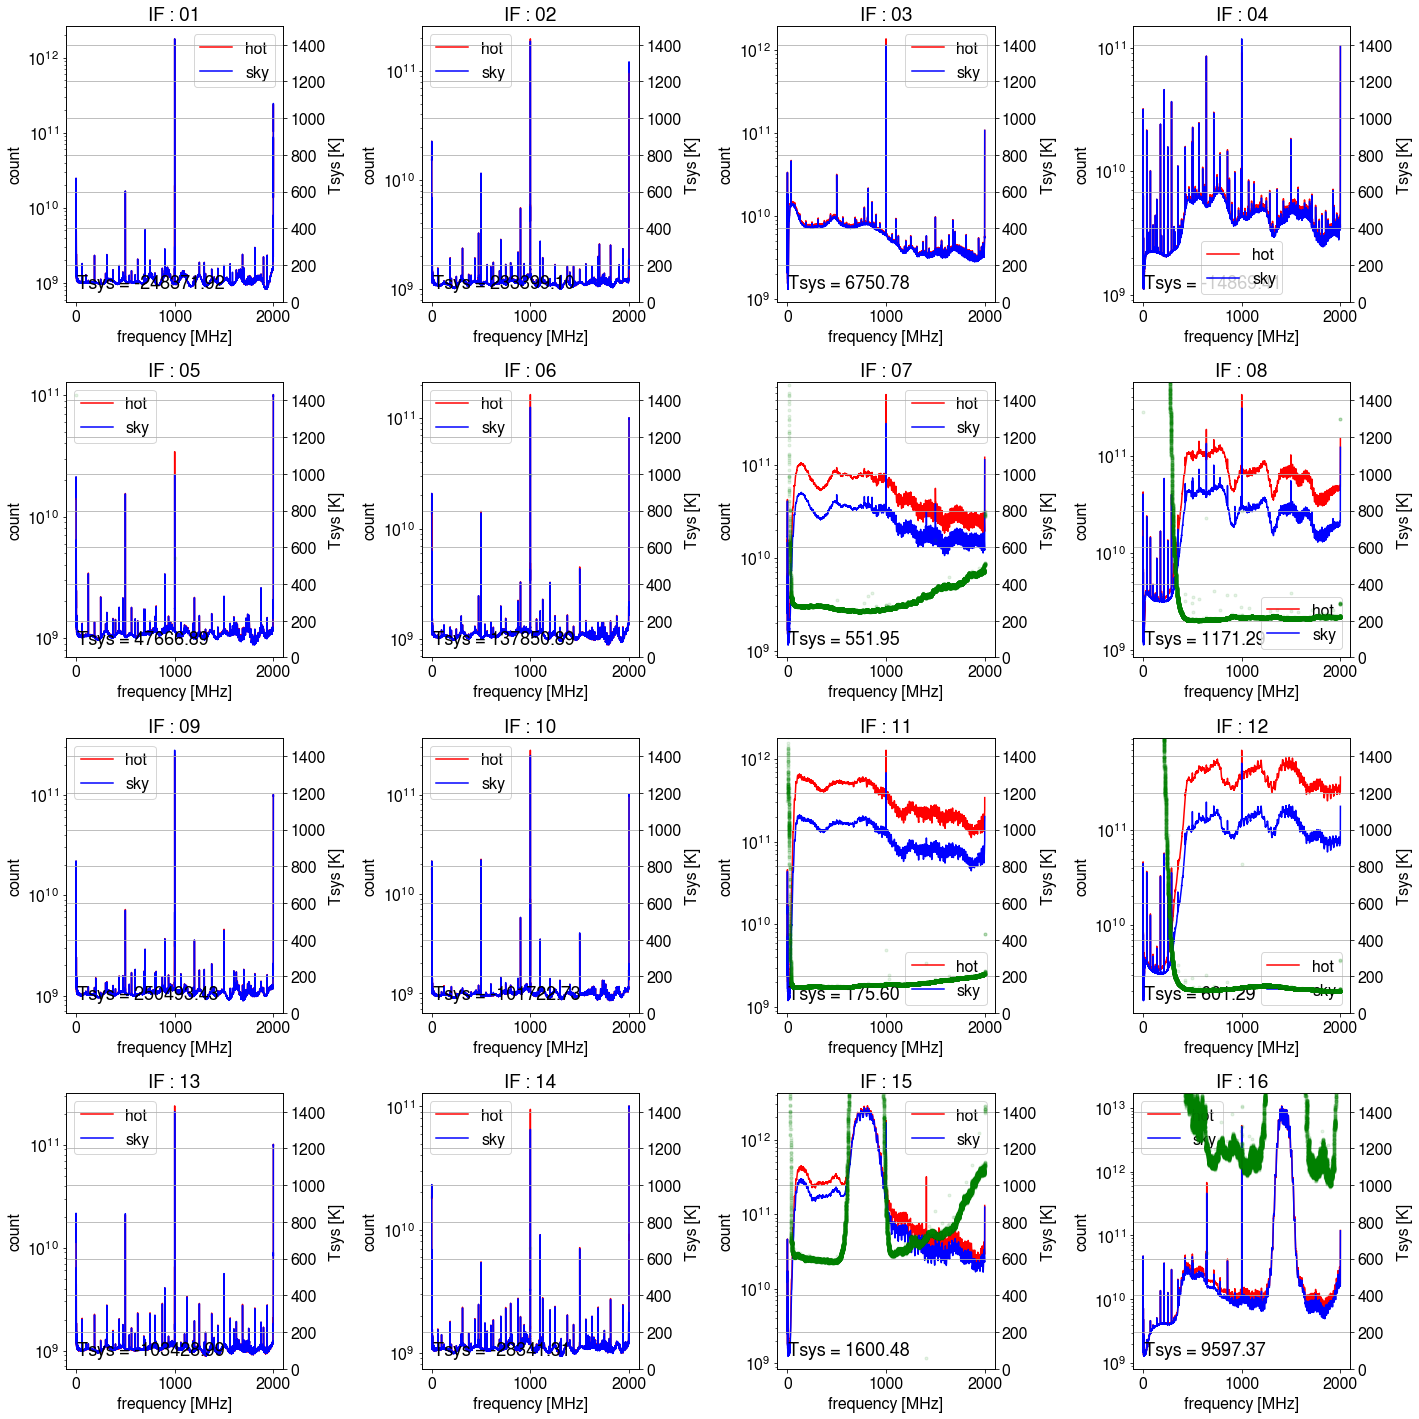

In [9]:
fig = plt.figure(figsize=(20,20))
ax = [fig.add_subplot(4, 4, i+1) for i in range(16)]
x = numpy.linspace(0, 2000, 32768)#プロットのため ch -->周波数
# plot hot
for i, (_ax, _tsys) in enumerate(zip(ax, tsys_list)):
    _ax.plot(x[ind1:ind2], numpy.mean(d[i].values[hotmask], axis=0)[ind1:ind2], "r-", label="hot")
    _ax.plot(x[ind1:ind2], numpy.mean(d[i].values[skymask], axis=0)[ind1:ind2], "b-", label="sky")
    _ax0 = _ax.twinx()
    _ax0.plot(x[ind1:ind2], tsys_list[i][ind1:ind2], "g.", label="Tsys", alpha=0.1)
    _ax.set_xlabel('frequency [MHz]')
    _ax.set_ylabel("count")
    _ax.set_yscale("log")
    _ax0.set_ylabel('Tsys [K]')
    _ax.set_title('IF : {}'.format(numlist[i]))
    tsys_av = numpy.mean(_tsys[ind1:ind2])
    _ax.text(0.05, 0.05, 'Tsys = %.2f'%(tsys_av), transform=_ax0.transAxes, fontsize=18)
    _ax0.set_ylim(0, 1500)
    _ax.legend()
    _ax0.grid()
plt.tight_layout()

In [10]:
result_path = path.replace("data", "analysis")
if not os.path.exists(result_path):
    os.makedirs(result_path, exist_ok=True)
plt.savefig("result_rsky.png")
if mode == "notebook":
    plt.show()

<Figure size 432x288 with 0 Axes>